In [155]:
import numpy as np
import pandas as pd

from pandas import read_csv
import datetime
from matplotlib import pyplot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pmdarima as pm
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")


In [156]:
zillow_df = pd.read_csv('zillow-carlifornia.csv')

### Initial Functions

In [157]:
def adf_test(timeseries):
    # Perform Augmented Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

def evaluate_ets_model(X, trend, seasonal,seasonal_periods):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = ExponentialSmoothing(X[:train_size+t], trend=trend,seasonal=seasonal,seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    #mae = skmetrics.mean_absolute_error(test, predictions)
    #rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return mape


def evaluate_sarima_model(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.67)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    #mae = skmetrics.mean_absolute_error(test, predictions)
    #rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return mape

<h3>Initial Exploration </h3>

In [158]:
zillow_df.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [159]:
zillow_df.shape

(107, 4)

In [160]:
zillow_df.describe()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
count,95.000000,107.000000,107.000000
mean,399105.263158,4.186542,6.823364
std,45971.423521,0.636049,1.183979
min,335000.000000,3.290000,4.700000
25%,360125.000000,3.780000,6.100000
50%,375000.000000,4.060000,7.000000
75%,440000.000000,4.430000,7.650000
max,489000.000000,6.030000,9.100000


In [161]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 107 non-null    object 
 1   MedianSoldPrice_AllHomes.California  95 non-null     float64
 2   MedianMortageRate                    107 non-null    float64
 3   UnemploymentRate                     107 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.5+ KB


In [162]:
zillow_df.columns

Index(['Date', 'MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [163]:
median_price_df=zillow_df[['Date', 'MedianSoldPrice_AllHomes.California']].copy()

In [164]:
median_price_df.set_index('Date',inplace=True)
median_price_df.head()

,MedianSoldPrice_AllHomes.California
Date,
2008-02-29,470000.0
2008-03-31,441000.0
2008-04-30,460000.0
2008-05-31,429000.0
2008-06-30,437500.0


In [165]:
df_train=median_price_df.dropna()
df_test=median_price_df[-12:]

In [166]:
len(df_train),len(df_test),len(zillow_df['MedianSoldPrice_AllHomes.California'])

(95, 12, 107)

In [167]:
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

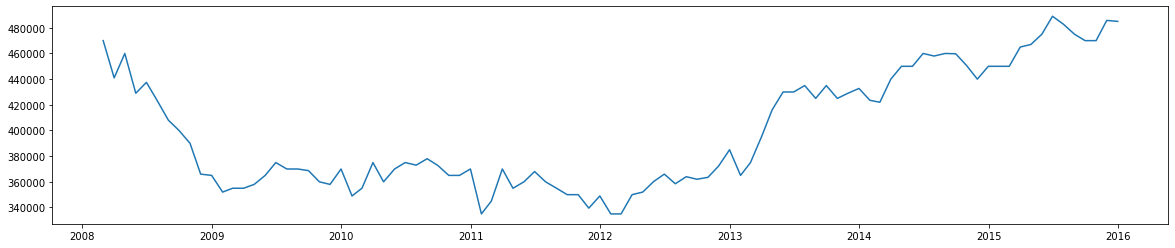

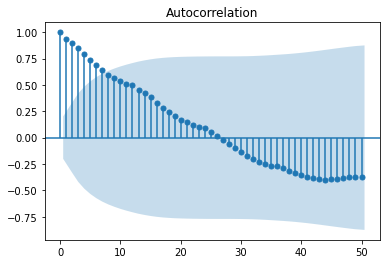

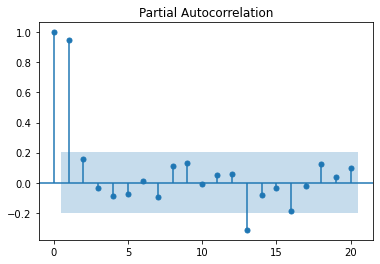

In [168]:
fig,ax=plt.subplots(figsize=(20,4))
ax.plot(df_train)
plt.show()
plot_acf(df_train,lags=50) 
plt.show()
plot_pacf(df_train,lags=20) 
plt.show()

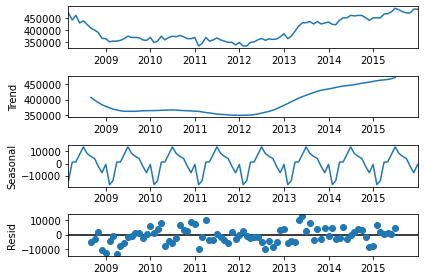

In [169]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_train, model='additive',freq=12)
result.plot()
plt.show()

In [170]:
adf_test(df_train)

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.058792
p-value                         0.953391
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


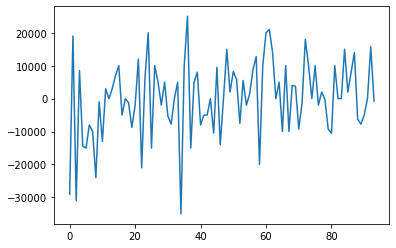

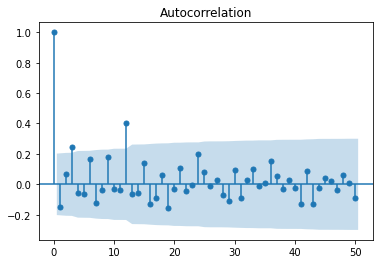

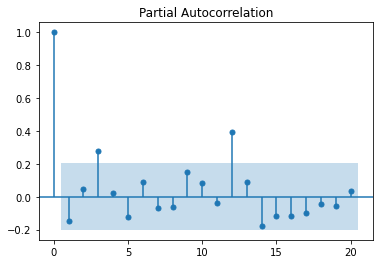

In [171]:
d1 = diff(df_train.values,interval=1)
plt.plot(d1)
plot_acf(d1,lags=50) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()

In [172]:
dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


In [173]:
## use differenced to move further on SARIMA - d1

### SARIMA

In [174]:
model = pm.auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=12,              
                      d=1,           
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=5, max_Q=5,
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1764.611, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1758.867, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1760.070, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1757.921, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1758.799, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1757.693, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1758.751, Time=0.10 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1758.695, Time=0.12 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=1749.836, Time=0.04 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1750.827, Time=0.13 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=1750.769, Time=0.13 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(4,1,0)(0,1,0)[12]          

In [175]:
# ARIMA(4,1,1)(0,1,0)[12]

In [176]:
evaluate_sarima_model(df_train,(4,1,1),(0,1,0,12))

100%|██████████| 32/32 [00:06<00:00,  5.22it/s]


0.018978383801810092

In [177]:
model_sarima = sm.tsa.statespace.SARIMAX(
    df_train, order=(4,1,1), seasonal_order=(0, 1, 0,12))
res2 = model_sarima.fit()
pred_sarima = res2.predict(start=len(df_train), end=len(
    df_train)+len(df_test)-1)

In [178]:
pred_sarima=pd.Series(pred_sarima)
pred_sarima.index=df_test.index


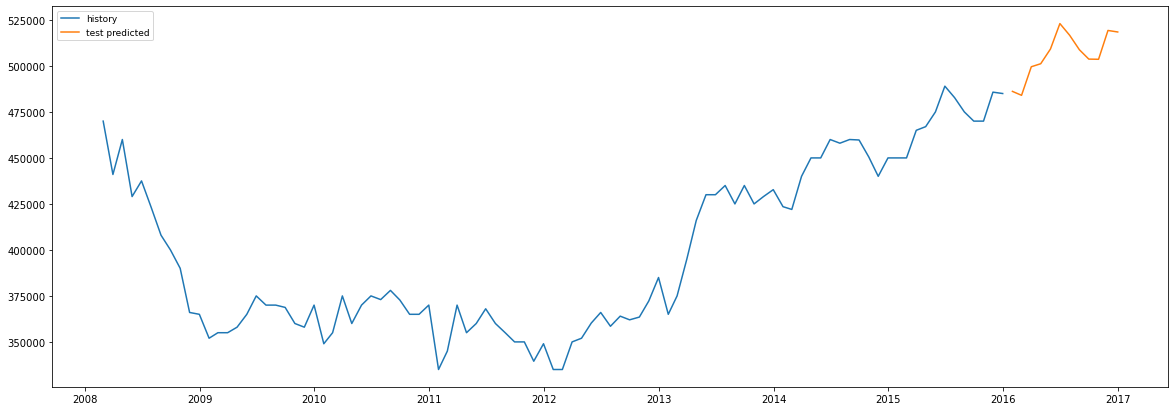

In [179]:
fig,ax=plt.subplots(figsize=(20,7))
plt.plot(df_train, label='history')
plt.plot(pred_sarima, label='test predicted')
plt.legend(loc='upper left', fontsize=9)
plt.show()

### ETS

In [180]:
mape1=evaluate_ets_model(df_train, trend="add", seasonal="add", seasonal_periods=12)
mape2=evaluate_ets_model(df_train, trend="add", seasonal="mul", seasonal_periods=12)
mape3=evaluate_ets_model(df_train, trend="mul", seasonal="add", seasonal_periods=12)
mape4=evaluate_ets_model(df_train, trend="mul", seasonal="mul", seasonal_periods=12)
mape5=evaluate_ets_model(df_train, trend=None, seasonal="add", seasonal_periods=12)
mape6=evaluate_ets_model(df_train, trend=None, seasonal="mul", seasonal_periods=12)


100%|██████████| 19/19 [00:00<00:00, 84.38it/s]


In [181]:
print(mape1, mape2, mape3, mape4, mape5, mape6)

0.017682217830061867 0.018147056541374915 8.393800795425246e+77 5.552184311281399e+93 0.017336774834160004 0.017506665281927885


In [182]:
# None-add

In [183]:
model_ets = ExponentialSmoothing(
    df_train, trend=None, seasonal="add", seasonal_periods=12)

fit_ets = model_ets.fit()
pred_ets = fit_ets.forecast(len(df_test))

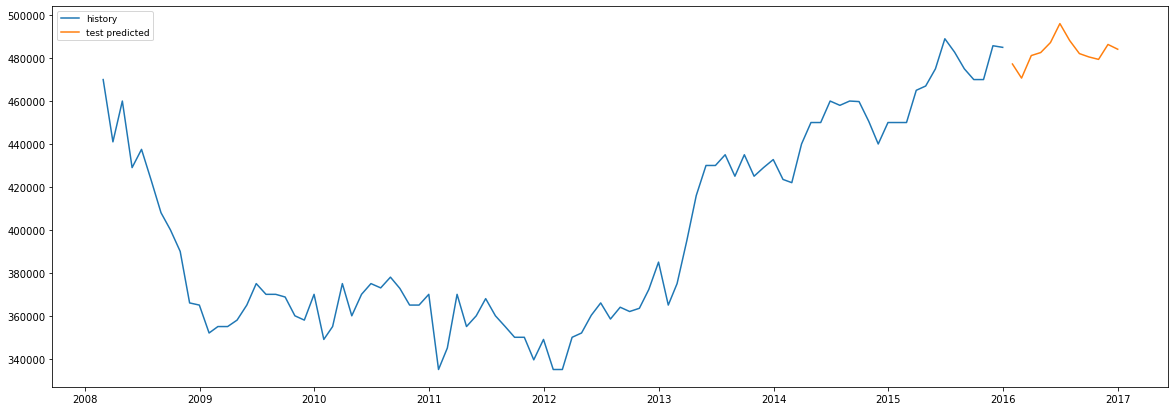

In [184]:
fig,ax=plt.subplots(figsize=(20,7))
plt.plot(df_train, label='history')
plt.plot(pred_ets, label='test predicted')
plt.legend(loc='upper left', fontsize=9)
plt.show()

### PROPHET

In [185]:
pf_train=df_train.copy().reset_index().rename(columns={'Date': 'ds','MedianSoldPrice_AllHomes.California': 'y'})

model_pf=Prophet()
model_pf.fit(pf_train)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


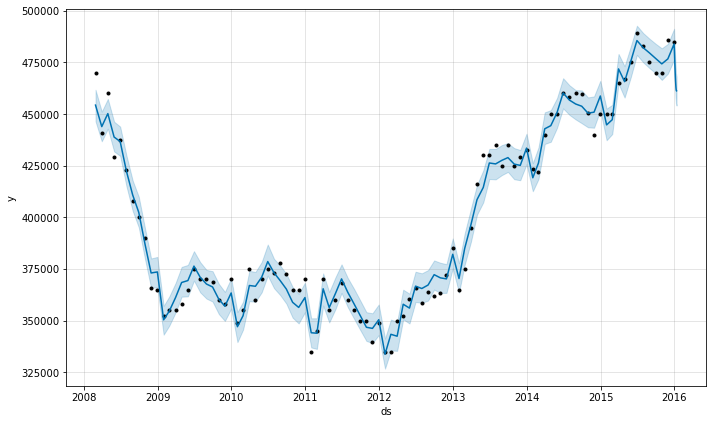

In [186]:
pf_test=df_test.copy().reset_index().rename(columns={'Date': 'ds','MedianSoldPrice_AllHomes.California': 'y'})

future = model_pf.make_future_dataframe(periods=len(pf_test))
forecast = model_pf.predict(future)
model_pf.plot(forecast)
plt.show()

In [187]:
forecast=forecast[-12:].copy()

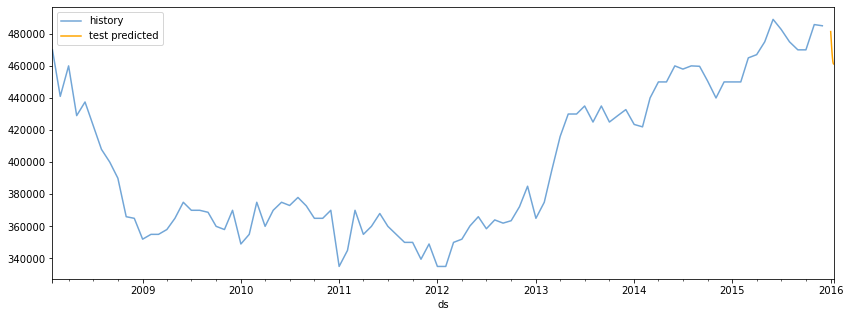

In [188]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
pf_train.plot(kind='line', x='ds', y='y', color='#72a6d7', label='history', ax=ax)
forecast.plot(kind='line', x='ds', y='yhat', color='Orange', label='test predicted', ax=ax)
plt.show()

In [189]:
# Load actual test data

In [190]:
actual_test=pd.read_csv('test.csv')
actual_test.set_index('Month',inplace=True)
actual_test.index = pd.to_datetime(actual_test.index)
actual_test

,Median House Price
Month,
2016-01-31,476250
2016-02-29,466000
2016-03-31,485000
2016-04-30,501000
2016-05-31,501000
2016-06-30,505000
2016-07-31,507000
2016-08-31,510000
2016-09-30,510000


In [201]:
## SARIMA
rmse_sarima=mean_squared_error(actual_test,pred_sarima)

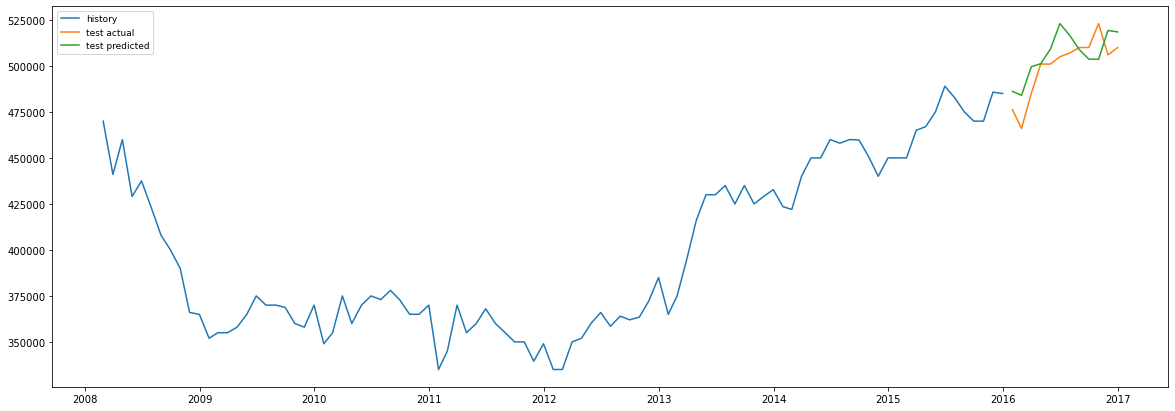

In [202]:
fig,ax=plt.subplots(figsize=(20,7))
plt.plot(df_train, label='history')
plt.plot(actual_test, label='test actual')
plt.plot(pred_sarima, label='test predicted')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [203]:
## ETS
rmse_ets=mean_squared_error(actual_test,pred_ets)

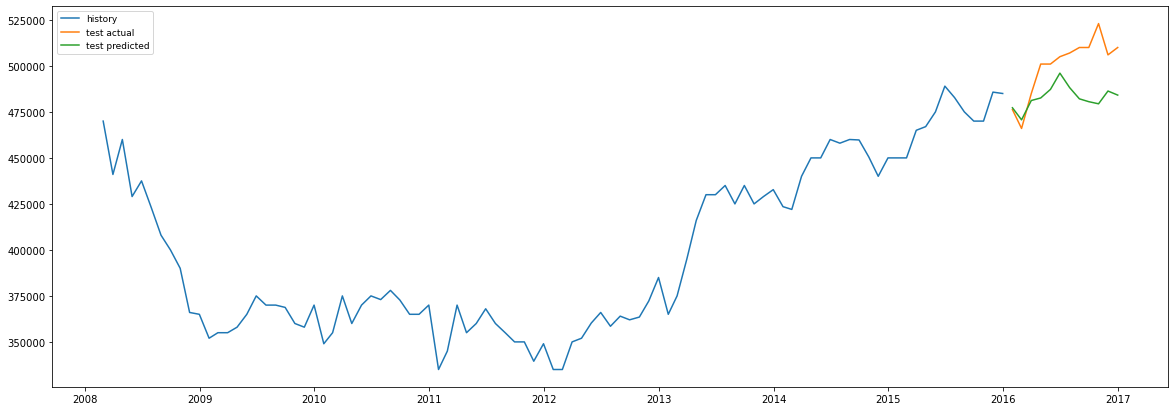

In [204]:
fig,ax=plt.subplots(figsize=(20,7))
plt.plot(df_train, label='history')
plt.plot(actual_test, label='test actual')
plt.plot(pred_ets, label='test predicted')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [205]:
##PROPHET
rmse_pf=mean_squared_error(actual_test,forecast['yhat'])

In [206]:
pf_test_actual = actual_test.copy().reset_index().rename(
    columns={'Month': 'ds', 'Median House Price': 'y'})

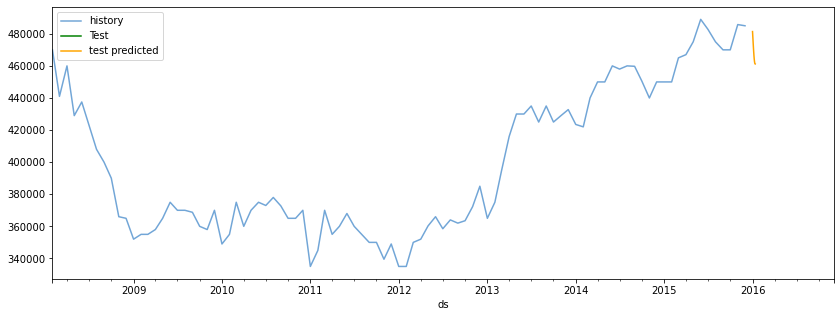

In [207]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
pf_train.plot(kind='line', x='ds', y='y', color='#72a6d7', label='history', ax=ax)
pf_test.plot(kind='line', x='ds', y='y', color='green', label='Test', ax=ax)
forecast.plot(kind='line', x='ds', y='yhat', color='Orange', label='test predicted', ax=ax)
plt.show()

In [209]:
print('SARIMA RMSE :', rmse_sarima )
print('ETS RMSE :' ,rmse_ets )
print('PROPHET RMSE :' ,rmse_pf )

SARIMA RMSE : 148746783.14460862
ETS RMSE : 466812810.6048476
PROPHET RMSE : 1449386405.6922457
